In [1]:
import os
import json
import argparse
import csv
from pathlib import Path
from subprocess import check_output
import time
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast

'''
Combines all the hyperparameter results into a single csv file by gping through all the output log files.
'''

'\nCombines all the hyperparameter results into a single csv file by gping through all the output log files.\n'

In [2]:
start_trial_index = 0
end_trial_index = 1000
model_type = 'attention_z'
snr_type = '' #'_high_snr'# or '' or '_runBC
output_csv = f'hyperparameter_tuning{snr_type}/{model_type}/results_{model_type}{snr_type}.csv'
list_of_dicts = json.load(open(f'hyperparameter_tuning{snr_type}/{model_type}/list_of_dicts_original.json', 'r'))
# dict_files = glob.glob(f'hyperparameter_tuning/{model_type}/result*.json')
# out_files = glob.glob(f'hyperparameter_tuning/{model_type}/*.out')
# error_files = glob.glob(f'hyperparameter_tuning/{model_type}/*.err')

In [3]:
list_of_dicts[853]

{'num_deep_layers': 10,
 'initial_learning_rate': 0.00048,
 'decay_rate': 0.7,
 'batch_size': 800,
 'num_cnn_layers': 4,
 'batch_normalization': False,
 'attention_type': 'multi_head',
 'num_attention_layers': 2,
 'index': 853,
 'deep_layer_size': '[200, 1784, 2248, 816, 40, 1936, 656, 2296, 2240, 2048]',
 'conv1d_kernel_size': '[23, 29, 13, 10]',
 'conv1d_filters': '[8, 16, 24, 32]',
 'num_attention_heads': 2,
 'num_key_dims': 16,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [3]:
result_df = pd.read_csv(output_csv)

FileNotFoundError: [Errno 2] No such file or directory: 'hyperparameter_tuning/attention_z/results_attention_z.csv'

In [4]:
# double or single index predictions
result_df = pd.DataFrame(columns=['index','success','accuracy','median',
                                'val_loss','test_loss','train_time','incomplete',
                                'accuracy_out','job_id'])
pattern = r"real\s+(\d+)m"
val_pattern = r"val_loss did not improve from (\d+\.\d+)"
acc_pattern = r"The accuracy of the model is:\[(\d+(\.\d+)?)\]"

out_files = glob.glob(f'hyperparameter_tuning{snr_type}/{model_type}/tuner_*.out')
error_files = glob.glob(f'hyperparameter_tuning{snr_type}/{model_type}/tuner_*.err')

for i,file in enumerate(out_files):
    print(file)
    file_ls = file.split('_')
    job_id = int(file_ls[-2])
    index = int(file_ls[-1][:-len('.out')])
    result_dicts_loc = f'hyperparameter_tuning{snr_type}/{model_type}/result_{index}_{job_id}_{index}.json'
    result_df.at[i,'job_id'] = job_id
    result_df.at[i,'index'] = index
    #check if result file exists
    if os.path.exists(result_dicts_loc):
        results_dict = json.load(open(result_dicts_loc, 'r'))
        result_df.at[i,'success'] = True
        result_df.at[i,'accuracy'] = results_dict['accuracy'][0]
        result_df.at[i,'median'] = results_dict['median'][0]
        result_df.at[i,'val_loss'] = results_dict['val_loss']
        result_df.at[i,'test_loss'] = results_dict['loss']
        result_df.at[i,'incomplete'] = False

    else:
        with open(file, 'r') as f:
            content = f.read()
            match = re.findall(val_pattern, content)
            if match:
                val_loss = float(match[-1])
                result_df.at[i,'val_loss'] = val_loss
            elif "as it failed in high snr" in content:
                result_df.at[i,'success'] = False
            else:
                result_df.at[i,'success'] = False
                #raise Exception(f'Neither dict nor val loss found for file {file}')
                continue


    error_file_loc = glob.glob(f'hyperparameter_tuning{snr_type}/{model_type}/tuner_{job_id}_{index}*.err')[0]
    max_time = 100000
    with open(error_file_loc, 'r') as f:
        content = f.read()
        matches = re.findall(pattern, content)
        if matches:
            max_time = int(matches[0])
        else:
            if 'DUE TO TIME LIMIT' in content:
                result_df.at[i,'incomplete'] = True
            else:
                #print(error_file_loc)
                #raise Exception('No time found')
                continue

    result_df.at[i,'train_time'] = max_time

result_df = result_df.astype({'index': 'int32', 'job_id': 'int32', 
                'success': 'bool', 'incomplete': 'bool',
                'accuracy':'float32','median':'float32',
                'test_loss':'float32','val_loss':'float32','train_time':'float32'})
result_df.to_csv(output_csv,
                index=False)

hyperparameter_tuning/attention_z/tuner_2544993_329.out
hyperparameter_tuning/attention_z/tuner_2546102_409.out
hyperparameter_tuning/attention_z/tuner_2547089_310.out
hyperparameter_tuning/attention_z/tuner_2547089_248.out
hyperparameter_tuning/attention_z/tuner_2544993_563.out
hyperparameter_tuning/attention_z/tuner_2546102_345.out
hyperparameter_tuning/attention_z/tuner_2546102_400.out
hyperparameter_tuning/attention_z/tuner_2535741_303.out
hyperparameter_tuning/attention_z/tuner_2538792_732.out
hyperparameter_tuning/attention_z/tuner_2538792_77.out
hyperparameter_tuning/attention_z/tuner_2546102_648.out
hyperparameter_tuning/attention_z/tuner_2546102_448.out
hyperparameter_tuning/attention_z/tuner_2547089_178.out
hyperparameter_tuning/attention_z/tuner_2546102_284.out
hyperparameter_tuning/attention_z/tuner_2544993_200.out
hyperparameter_tuning/attention_z/tuner_2536743_3.out
hyperparameter_tuning/attention_z/tuner_2535741_301.out
hyperparameter_tuning/attention_z/tuner_2546102_523

In [6]:
result_df

,index,success,accuracy,median,val_loss,test_loss,train_time,incomplete,accuracy_out,job_id
0,329,True,1.576577,26.810083,452.721100,457.605682,28.0,False,NaN,2544993
1,409,False,NaN,NaN,NaN,NaN,NaN,True,NaN,2546102
2,310,True,0.000000,100.000000,3392.486572,3264.131348,2.0,False,NaN,2547089
3,248,False,NaN,NaN,NaN,NaN,NaN,True,NaN,2547089
4,563,True,1.576577,24.902481,402.586365,423.364716,6.0,False,NaN,2544993
...,...,...,...,...,...,...,...,...,...,...
5359,882,False,NaN,NaN,NaN,NaN,NaN,True,NaN,2546102
5360,599,False,NaN,NaN,NaN,NaN,0.0,True,NaN,2535741
5361,16,True,0.000000,100.000000,3392.486572,3264.131348,234.0,False,NaN,2535741
5362,580,True,0.525526,40.787460,858.895935,817.054871,332.0,False,NaN,2546102


In [8]:
result_df.loc[result_df['accuracy'].idxmax()]

index               241
success            True
accuracy        2.02703
median          23.6677
val_loss        420.331
test_loss        457.34
train_time           48
incomplete        False
accuracy_out        NaN
job_id          2538792
Name: 1142, dtype: object

In [7]:
result_df[result_df['accuracy']>40]

,index,success,accuracy,median,val_loss,test_loss,train_time,incomplete,accuracy_out,job_id


In [9]:
list_of_dicts[427]

{'num_deep_layers': 10,
 'initial_learning_rate': 0.00014,
 'decay_rate': 0.7,
 'batch_size': 800,
 'num_cnn_layers': 6,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 2,
 'index': 427,
 'deep_layer_size': '[56, 112, 168, 224, 280, 336, 392, 448, 504, 560]',
 'conv1d_kernel_size': '[32, 18, 23, 25, 46, 7]',
 'conv1d_filters': '[176, 352, 528, 704, 880, 1056]',
 'num_attention_heads': 2,
 'num_key_dims': 528,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [9]:
result_df.loc[result_df['accuracy'].idxmax()]

index               241
success            True
accuracy        2.02703
median          23.6677
val_loss        420.331
test_loss        457.34
train_time           48
incomplete        False
accuracy_out        NaN
job_id          2538792
Name: 1142, dtype: object

In [11]:
result_df[result_df['index']==853]

,index,success,accuracy,median,val_loss,test_loss,train_time,incomplete,accuracy_out,job_id
939,853,True,1.126126,23.435814,381.773560,402.216766,11.0,False,NaN,2538792
1487,853,True,2.027027,24.895309,392.716522,409.628479,9.0,False,NaN,2535741
1998,853,True,0.000000,100.000000,3392.486572,3264.131348,4.0,False,NaN,2536743
4571,853,False,NaN,NaN,NaN,NaN,NaN,True,NaN,2544993
4679,853,False,NaN,NaN,NaN,NaN,NaN,True,NaN,2546102


In [12]:
list_of_dicts[853]

{'num_deep_layers': 10,
 'initial_learning_rate': 0.00048,
 'decay_rate': 0.7,
 'batch_size': 800,
 'num_cnn_layers': 4,
 'batch_normalization': False,
 'attention_type': 'multi_head',
 'num_attention_layers': 2,
 'index': 853,
 'deep_layer_size': '[200, 1784, 2248, 816, 40, 1936, 656, 2296, 2240, 2048]',
 'conv1d_kernel_size': '[23, 29, 13, 10]',
 'conv1d_filters': '[8, 16, 24, 32]',
 'num_attention_heads': 2,
 'num_key_dims': 16,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [1]:
result_df[result_df['index']==742]

NameError: name 'result_df' is not defined

In [38]:
list_of_dicts[742]

{'num_deep_layers': 8,
 'initial_learning_rate': 0.00014,
 'decay_rate': 0.75,
 'batch_size': 400,
 'num_cnn_layers': 8,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 1,
 'index': 742,
 'deep_layer_size': '[16, 32, 48, 64, 80, 96, 112, 128]',
 'conv1d_kernel_size': '[5, 14, 55, 23, 9, 49, 41, 22]',
 'conv1d_filters': '[720, 640, 560, 480, 400, 320, 240, 160]',
 'num_attention_heads': 2,
 'num_key_dims': 40,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [66]:
def sliding_window_average(arr, window_size):
    averages = []
    for i in range(len(arr)//window_size + 1):
        window = arr[i*window_size:(i+1)*window_size]
        average = sum(window) / window_size
        averages.append(average)
    return averages

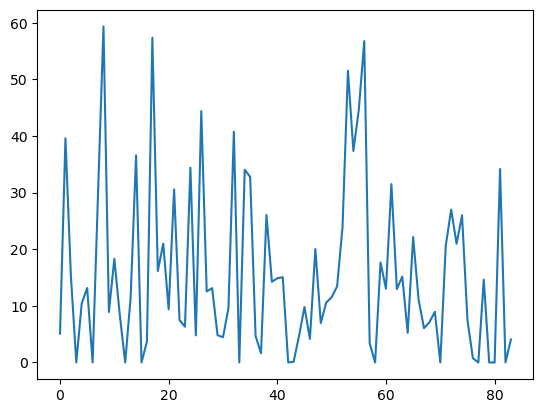

In [67]:
plt.plot(sliding_window_average(result_df['accuracy_out'][1:], 12))

In [68]:
np.argmax(sliding_window_average(result_df['accuracy_out'][1:], 12))

8

In [70]:
sliding_window_average(result_df['accuracy_out'][1:], 12)[45:60]

[9.791666984558105,
 4.166666666666667,
 20.020833015441895,
 6.958333333333333,
 10.583333333333334,
 11.520833333333334,
 13.4375,
 23.875000317891438,
 51.52083396911621,
 37.35416730244955,
 44.66666682561239,
 56.750000953674316,
 3.375,
 0.0,
 17.645833174387615]

In [71]:
list_of_dicts[673]

{'num_deep_layers': 10,
 'initial_learning_rate': 0.00018,
 'decay_rate': 0.75,
 'batch_size': 400,
 'num_cnn_layers': 4,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 2,
 'index': 673,
 'deep_layer_size': '[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]',
 'conv1d_kernel_size': '[7, 14, 21, 28]',
 'conv1d_filters': '[152, 304, 456, 608]',
 'num_attention_heads': 16,
 'num_key_dims': 38,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [74]:
list_of_dicts[104]

{'num_deep_layers': 8,
 'initial_learning_rate': 0.00026,
 'decay_rate': 0.75,
 'batch_size': 400,
 'num_cnn_layers': 2,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 4,
 'index': 104,
 'deep_layer_size': '[1648, 120, 1840, 920, 1312, 96, 640, 1544]',
 'conv1d_kernel_size': '[18, 12]',
 'conv1d_filters': '[320, 216]',
 'num_attention_heads': 12,
 'num_key_dims': 18,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [73]:
result_df['accuracy_out'][90:120]

90      58.5
91     42.25
92     57.75
93         0
94        36
95         0
96     33.75
97         0
98     62.75
99      70.5
100    58.75
101       67
102     65.5
103       55
104     72.5
105     66.5
106     67.5
107    59.25
108    66.75
109        9
110    10.25
111      3.5
112    12.25
113     4.75
114    10.25
115        8
116       12
117        6
118      8.5
119     9.75
Name: accuracy_out, dtype: object

In [62]:
print(result_df['accuracy_out'][650:700])

650        0
651        0
652    53.25
653     65.5
654        0
655    15.25
656    71.75
657    53.25
658       71
659    67.75
660        0
661    66.75
662    56.25
663    44.75
664       60
665       44
666        0
667    29.25
668     37.5
669       61
670     43.5
671    56.75
672    36.25
673    71.75
674       61
675    64.25
676    59.75
677    64.75
678    53.75
679     62.5
680     66.5
681    45.25
682    25.25
683    59.75
684     46.5
685        0
686        0
687        0
688        0
689        0
690        0
691        0
692        0
693        0
694        0
695        0
696     40.5
697        0
698        0
699        0
Name: accuracy_out, dtype: object


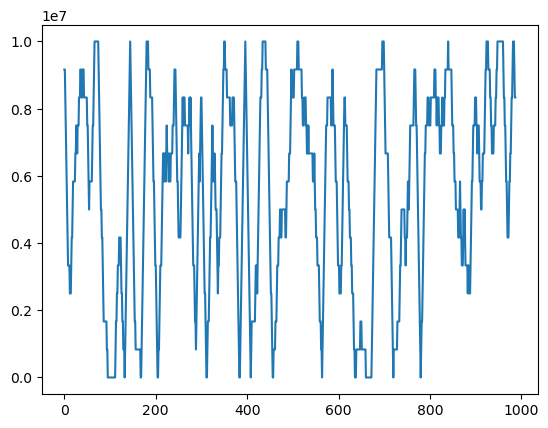

In [65]:
plt.plot(sliding_window_average(result_df['val_loss'][1:], 12))

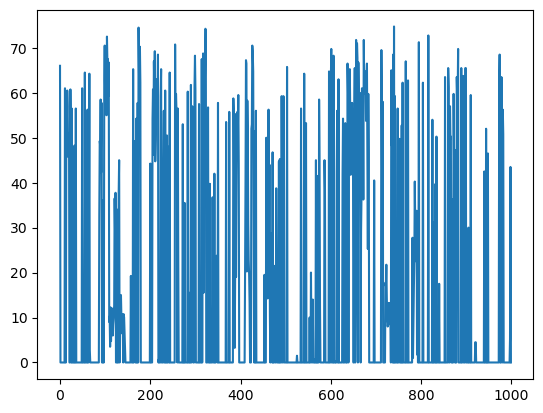

In [44]:
plt.plot(result_df['accuracy_out'])

In [42]:
result_df_z['accuracy_out'][620:660]

620        0
621        0
622        0
623        0
624        0
625        0
626        0
627        0
628        0
629        0
630        0
631        0
632        0
633        0
634        0
635        0
636        0
637       56
638        0
639       66
640    64.75
641     0.25
642    58.75
643    61.25
644     0.25
645     0.75
646      0.5
647        0
648     0.75
649        0
650        0
651        0
652        0
653        0
654        0
655        0
656        0
657        0
658        0
659        0
Name: accuracy_out, dtype: object

In [35]:
result_df.loc[323]

index                323
success             True
accuracy            54.5
median          0.434927
val_loss         0.06717
test_loss       0.261323
train_time           243
incomplete           NaN
accuracy_out          74
Name: 323, dtype: object

In [34]:
list_of_dicts[323]

{'num_deep_layers': 4,
 'initial_learning_rate': 0.00023,
 'decay_rate': 0.65,
 'batch_size': 400,
 'num_cnn_layers': 2,
 'batch_normalization': False,
 'attention_type': 'multi_head',
 'num_attention_layers': 1,
 'index': 323,
 'deep_layer_size': '[1120, 896, 672, 448]',
 'conv1d_kernel_size': '[15, 10]',
 'conv1d_filters': '[360, 240]',
 'num_attention_heads': 15,
 'num_key_dims': 8,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [12]:
result_df.loc[738]

index                738
success             True
accuracy            68.5
median          0.299715
val_loss         0.18263
test_loss        0.23897
train_time           540
incomplete          True
accuracy_out        68.5
Name: 738, dtype: object

In [9]:
result_df.loc[322]

index               322
success            True
accuracy              0
median              100
val_loss        0.05442
test_loss       3290.67
train_time          118
incomplete          NaN
accuracy_out      74.25
Name: 322, dtype: object

In [53]:
result_df.loc[125]

index                125
success             True
accuracy              84
median          0.200247
val_loss         0.61499
test_loss       0.487145
train_time            14
incomplete           NaN
accuracy_out       87.75
Name: 125, dtype: object

In [31]:
result_df.loc[738]

index                738
success             True
accuracy            68.5
median          0.299715
val_loss         0.18263
test_loss        0.23897
train_time           540
incomplete          True
accuracy_out        68.5
Name: 738, dtype: object

In [8]:
result_df.max()

index           9.990000e+02
success         1.000000e+00
accuracy        6.850000e+01
median          1.000000e+02
val_loss        1.000000e+07
test_loss       3.290667e+03
train_time      5.400000e+02
incomplete      1.000000e+00
accuracy_out    7.475000e+01
dtype: float64

In [33]:
list_of_dicts[740]

{'num_deep_layers': 8,
 'initial_learning_rate': 0.00014,
 'decay_rate': 0.75,
 'batch_size': 400,
 'num_cnn_layers': 8,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 1,
 'index': 740,
 'deep_layer_size': '[16, 32, 48, 64, 80, 96, 112, 128]',
 'conv1d_kernel_size': '[4, 8, 12, 16, 20, 24, 28, 32]',
 'conv1d_filters': '[792, 704, 616, 528, 440, 352, 264, 176]',
 'num_attention_heads': 11,
 'num_key_dims': 8,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [47]:
len([round(i, 5) for i in np.logspace(-4, -3, 30)])

30

In [30]:
list_of_dicts[738]

{'num_deep_layers': 8,
 'initial_learning_rate': 0.00014,
 'decay_rate': 0.75,
 'batch_size': 400,
 'num_cnn_layers': 8,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 1,
 'index': 738,
 'deep_layer_size': '[240, 480, 720, 960, 1200, 1440, 1680, 1920]',
 'conv1d_kernel_size': '[27, 24, 21, 18, 15, 12, 9, 6]',
 'conv1d_filters': '[1664, 976, 776, 992, 1888, 1432, 376, 384]',
 'num_attention_heads': 4,
 'num_key_dims': 96,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [5]:
result_df.max()

index         9.990000e+02
success       1.000000e+00
accuracy      9.475000e+01
median        1.000000e+02
val_loss      1.000000e+07
test_loss     5.013529e+04
train_time    5.400000e+02
incomplete    1.000000e+00
dtype: float64

In [11]:
np.argmax(result_df['accuracy'])

832

In [7]:
list_of_dicts[738]

{'num_deep_layers': 8,
 'initial_learning_rate': 0.00014,
 'decay_rate': 0.75,
 'batch_size': 400,
 'num_cnn_layers': 8,
 'batch_normalization': False,
 'attention_type': 'simple',
 'num_attention_layers': 1,
 'index': 738,
 'deep_layer_size': '[240, 480, 720, 960, 1200, 1440, 1680, 1920]',
 'conv1d_kernel_size': '[27, 24, 21, 18, 15, 12, 9, 6]',
 'conv1d_filters': '[1664, 976, 776, 992, 1888, 1432, 376, 384]',
 'num_attention_heads': 4,
 'num_key_dims': 96,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [12]:
list_of_dicts[832]

{'num_deep_layers': 2,
 'initial_learning_rate': 0.00043,
 'decay_rate': 0.5,
 'batch_size': 400,
 'num_cnn_layers': 12,
 'batch_normalization': True,
 'attention_type': 'simple',
 'num_attention_layers': 2,
 'index': 832,
 'deep_layer_size': '[96, 192]',
 'conv1d_kernel_size': '[29, 83, 26, 93, 95, 15, 35, 70, 3, 41, 69, 22]',
 'conv1d_filters': '[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480]',
 'num_attention_heads': 8,
 'num_key_dims': 60,
 'epochs': 20000,
 'patience': 400,
 'input_shape': [400, 1]}

In [10]:
dicts_df = pd.DataFrame(list_of_dicts)
# merge the two dataframes using the index
result_df = result_df.merge(dicts_df, left_on='index', right_on='index')

In [11]:
result_df.columns

Index(['index', 'success', 'accuracy', 'median', 'val_loss', 'test_loss',
       'train_time', 'incomplete', 'num_cnn_layers', 'num_deep_layers',
       'initial_learning_rate', 'decay_rate', 'batch_size', 'deep_layer_size',
       'epochs', 'patience', 'input_shape', 'padding', 'dilation',
       'conv1d_filters', 'conv1d_kernel_size', 'batch_normalization',
       'dilation_rate_size'],
      dtype='object')

In [ ]:
# Assuming you have a DataFrame called 'df' with your data
result_df_temp = result_df[['index', 'accuracy', 'val_loss',
       'train_time', 'num_cnn_layers', 'num_deep_layers',
       'initial_learning_rate', 'decay_rate', 'batch_size','average_deep_layers',
       'average_kernel_size','average_filter_size']]
result_df_nonan = result_df_temp.dropna().astype(float)
correlation_matrix = result_df_nonan.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlBu")
plt.title("Variable Correlation Heatmap")
plt.show()

In [9]:
result_df.columns

Index(['index', 'success', 'accuracy', 'median', 'val_loss', 'test_loss',
       'train_time', 'incomplete', 'num_cnn_layers', 'num_deep_layers',
       'initial_learning_rate', 'decay_rate', 'batch_size', 'deep_layer_size',
       'epochs', 'patience', 'input_shape', 'padding', 'dilation',
       'conv1d_filters', 'conv1d_kernel_size', 'batch_normalization',
       'dilation_rate_size'],
      dtype='object')

In [13]:
result_df['average_kernel_size'] = result_df['conv1d_kernel_size'].apply(lambda x: np.mean(ast.literal_eval(x)))
result_df['average_filter_size'] = result_df['conv1d_filters'].apply(lambda x: np.mean(ast.literal_eval(x)))
result_df['average_deep_layers'] = result_df['deep_layer_size'].apply(lambda x: np.mean(ast.literal_eval(x)))

In [ ]:
dilation_rate_size = ast.literal_eval(param_dict['dilation_rate_size'])

In [ ]:
sns.pairplot(result_df_nonan)

In [12]:
result_df.columns

Index(['index', 'success', 'accuracy', 'median', 'val_loss', 'test_loss',
       'train_time', 'incomplete', 'num_cnn_layers', 'num_deep_layers',
       'initial_learning_rate', 'decay_rate', 'batch_size', 'deep_layer_size',
       'epochs', 'patience', 'input_shape', 'padding', 'dilation',
       'conv1d_filters', 'conv1d_kernel_size', 'batch_normalization',
       'dilation_rate_size', 'average_kernel_size', 'average_filter_size',
       'average_deep_layers'],
      dtype='object')

In [ ]:
result_df_fil = result_df[result_df['accuracy']>80]
plt.plot(result_df['accura'])

71.01724147796631


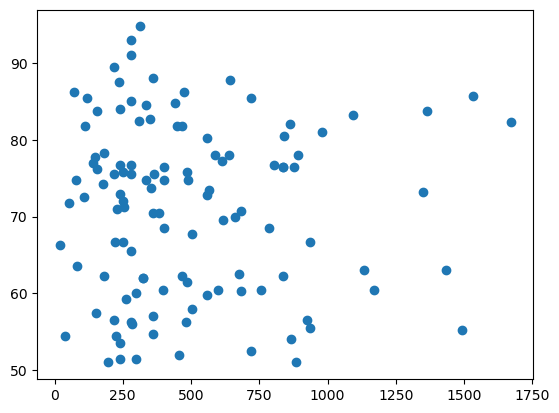

In [18]:
result_df_fil = result_df[result_df['accuracy']>50]
plt.scatter(result_df_fil['average_deep_layers'],result_df_fil['accuracy'])
print(result_df_fil['accuracy'].mean())

71.01724147796631


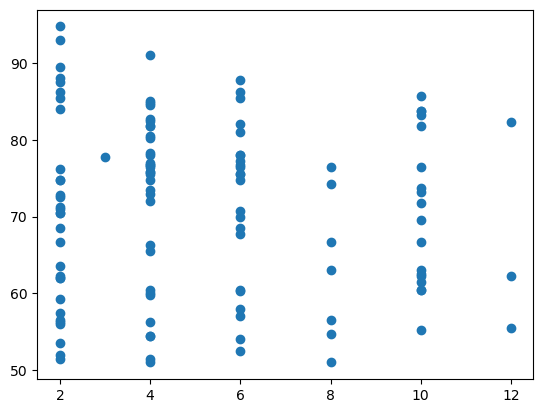

In [7]:
result_df_fil = result_df[result_df['accuracy']>50]
plt.scatter(result_df_fil['num_deep_layers'],result_df_fil['accuracy'])
print(result_df_fil['accuracy'].mean())

11.717703352704573


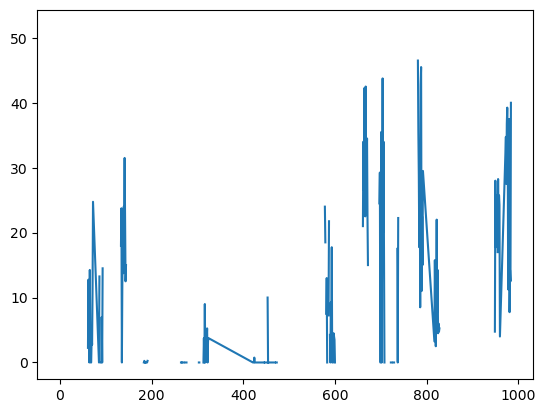

In [17]:
result_df_fil = result_df[result_df['batch_normalization'] == False]
plt.plot(result_df_fil['index'],result_df_fil['accuracy'])
print(np.mean(result_df_fil['accuracy']))

In [ ]:
sns.pairplot(result_df_nonan)

In [ ]:
np.argmax(result_df['train_time'])

In [ ]:
result_df.loc[319]

In [ ]:
result_df['train_time']

In [ ]:
result_df['val_loss'].min()

In [ ]:
result_df[result_df['train_time'] > 500]

In [ ]:
plt.scatter(result_df['train_time'],result_df['val_loss'])
plt.ylim(0,1000)

In [ ]:
result_df.loc[14]

In [ ]:
result_df[result_df['success']]

In [ ]:

if all_results:
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=['trial', 'val_loss', 'mse',
                                        'mae', 'accuracy', 'median',
                                        'num_deep_layers','average_deep_layers',
                                        'average_kernel_size','average_filter_size'])

    for result in all_results:
        results_df = results_df.append(result, ignore_index=True)

    results_df.to_csv(output_csv, index=False)

else:
    print("No results found.")

print('Indices that were not found are:', trials_not_found)


In [ ]:
results_df.iloc[results_df['val_loss'].idxmin()]

In [ ]:
import re

text = '''val_loss did not improve from 0.58202 
 val_loss did not improve from 0.58203'''

pattern = r"did not improve from (\d+\.\d+)"

match = re.findall(pattern, text)
if match:
    val_loss = match[-1]
    print("Val loss:", val_loss)

In [ ]:
match

# Script to combine results for the case of tuning of the diluted time based segmented data
import os
import json
import argparse
import csv
from pathlib import Path
from subprocess import check_output
import time
import pandas as pd
import glob
import re

'''
Combines all the hyperparameter results into a single csv file by gping through all the output log files.
'''

start_trial_index = 1
end_trial_index = 1000
output_csv = 'temp_hyperparameter.csv'
input_csv = 'meta_data/hyperparameters.csv'
hyperparameters_df = pd.read_csv('meta_data/hyperparameters.csv',delimiter=';')
dict_files = glob.glob('logs/results_trial_*.json')
out_files = glob.glob('logs/output.train.*')
error_files = glob.glob('logs/error.train.*')
all_results = []
pattern_trial = re.compile('trial: (\d+)')
pattern_job_id = re.compile('train.(\d+)')
trials_not_found = []
for i in range(len(out_files)):
    with open(out_files[i], 'r') as f:
        content = f.read()
    try: 
        trial_index = int(pattern_trial.findall(content)[0])
        job_id = int(pattern_job_id.findall(out_files[i])[0])

        error_log_file = Path(f'logs/error.train.{job_id}')
        result_file = Path(f'logs/results_trial_{trial_index}.json')
        row = hyperparameters_df.loc[hyperparameters_df['trial']==trial_index,
                                    ['trial','num_cnn_layers','num_deep_layers',
                                    'pool_size','num_param','memory','negative_value_error']]
        
        result_dict = row.to_dict('records')[0]
        result_dict['job_id'] = job_id
        
        if result_file.is_file():
            with open(result_file, 'r') as f:
                result_data = json.load(f)
                for key in ['val_loss','mse','mae','accuracy','median']:
                    result_dict[key] = float(result_data[key])
        else:
            result_dict['error'] = 'NotFound.'
        
        if error_log_file.is_file():
            with open(error_log_file, 'r') as f:
                error_log = f.read()
                if 'task 0: Exited with exit code 1' in error_log:
                    result_dict['error'] = 'OOM'

                elif 'task 0: Aborted' in error_log:
                    result_dict['error'] = 'Aborted'

        all_results.append(result_dict)
    except IndexError:
        trials_not_found.append(out_files[i])
        continue


if all_results:
    # Create a DataFrame to store the results
    results_df = pd.DataFrame(columns=['trial', 'val_loss', 'mse',
                                        'mae', 'accuracy', 'median',
                                        'num_param','memory','error',
                                        'num_cnn_layers','num_deep_layers',
                                        'pool_size','job_id','negative_value_error'])

    for result in all_results:
        results_df = results_df.append(result, ignore_index=True)

    results_df.to_csv(output_csv, index=False)

else:
    print("No results found.")

print('Indices that were not found are:', trials_not_found)



In [31]:
[round(i, 2) for i in np.arange(0.5, 0.8, 0.05)]

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]